In [63]:
import urllib.request
import pandas
import xml.etree.ElementTree as ET

import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from datetime import timedelta

# 한글 폰트 설정
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [64]:
def query_sender(date, date_1, last_year, kinds):
    url='http://www.garak.co.kr/publicdata/dataOpen.do?id=2956&passwd=qwert1324!&' \
    'dataid=data4&pagesize=1000&pageidx=1&portal.templet=false&'

    kinds = urllib.parse.quote(kinds)
    code_info='p_ymd=' + date+'&p_jymd='+date_1+'&d_cd=2&p_jjymd='+last_year
    code_info_2='&p_pos_gubun=9&pum_nm='+kinds

    request = urllib.request.Request(url+code_info+code_info_2)
    request.get_method=lambda :'GET'
    response_body=urllib.request.urlopen(request).read()
    u=str(response_body,'utf-8')
    return u

In [65]:
def xml_to_item_list(xml_string, date):
    result=[]
    root = ET.fromstring(xml_string)
    for child in root:
        item_list=[]
        item_list.append(date)
        for list in child:
            if list.tag in ['PUM_NM_A', 'AV_P_A', 'PAV_P_A', 'PAV_PY_A', 'E_NAME']:
                item_list.append(list.text)
                #print(list.text)
        result.append(item_list)

    return result

In [66]:
# 상 데이터만 먼저 사용
df = pd.read_csv('./data/average.csv', index_col = 0)
display(df.head())

,날짜,품목명,평균가격,전일평균가격,전년가격,등급,평균기온,강수량
2,20170101,대파(일반),1556.3,1747.0,0.0,중,4.3,0.0
7,20170103,대파(일반),1747.0,0.0,1611.0,중,5.1,0.0
11,20170104,대파(일반),2000.0,1747.0,1797.0,중,4.4,0.0
15,20170105,대파(일반),2000.0,2000.0,1707.0,중,7.5,0.5
19,20170106,대파(일반),2000.0,2000.0,1566.0,중,7.2,0.2


### LSTM 모델링

In [67]:
# 굳이 csv로 저장 하지 않아도 되지만, 여러번 실험하기 위해 계속 데이터를 불러와서
# 자르고 나누고 하는 것 보다 정제된 데이터를 저장해야 겠다 생각하여 상 데이터를 저장해놓은
# best.csv 파일이다.

df['날짜'] = df['날짜'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df = df.set_index('날짜')

display(df)

,품목명,평균가격,전일평균가격,전년가격,등급,평균기온,강수량
날짜,,,,,,,
2017-01-01,대파(일반),1556.3,1747.0,0.0,중,4.3,0.0
2017-01-03,대파(일반),1747.0,0.0,1611.0,중,5.1,0.0
2017-01-04,대파(일반),2000.0,1747.0,1797.0,중,4.4,0.0
2017-01-05,대파(일반),2000.0,2000.0,1707.0,중,7.5,0.5
2017-01-06,대파(일반),2000.0,2000.0,1566.0,중,7.2,0.2
...,...,...,...,...,...,...,...
2021-05-23,대파(일반),1556.3,1726.0,1400.0,중,19.7,0.0
2021-05-24,대파(일반),1540.0,0.0,0.0,중,17.6,0.0
2021-05-25,대파(일반),1676.0,1540.0,1420.0,중,17.3,0.0


In [68]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.unicode_minus'] = False



In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1581 entries, 2017-01-01 to 2021-05-27
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   품목명     1581 non-null   object 
 1   평균가격    1581 non-null   float64
 2   전일평균가격  1581 non-null   float64
 3   전년가격    1581 non-null   float64
 4   등급      1581 non-null   object 
 5   평균기온    1581 non-null   float64
 6   강수량     1581 non-null   float64
dtypes: float64(5), object(2)
memory usage: 98.8+ KB


<AxesSubplot:xlabel='날짜'>

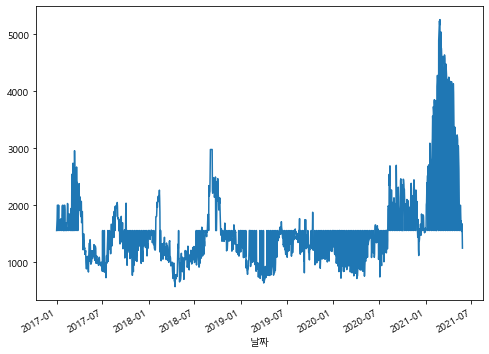

In [70]:
plt.rc('font', family='Malgun Gothic')
df['평균가격'].plot()

<AxesSubplot:xlabel='날짜'>

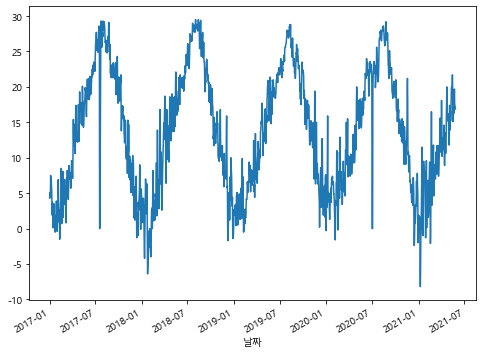

In [71]:
plt.rc('font', family='Malgun Gothic')
df['평균기온'].plot()


### 데이터 정규화

In [72]:
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()
scale_cols=['평균가격','평균기온','강수량']
dfs1 = scaler1.fit_transform(df[['평균가격']])
dfs2 = scaler2.fit_transform(df[['평균기온']])
dfs3 = scaler3.fit_transform(df[['강수량']])

df_scaled = pd.DataFrame()
df_scaled=pd.DataFrame(dfs1)
df_scaled.columns=['평균가격']
df_scaled['평균기온'] = pd.DataFrame(dfs2)
df_scaled['강수량'] = pd.DataFrame(dfs3)

print(df_scaled)

          평균가격      평균기온       강수량
0     0.210231  0.331565  0.000000
1     0.250961  0.352785  0.000000
2     0.304998  0.334218  0.000000
3     0.304998  0.416446  0.001639
4     0.304998  0.408488  0.000656
...        ...       ...       ...
1576  0.210231  0.740053  0.000000
1577  0.206749  0.684350  0.000000
1578  0.235797  0.676393  0.000000
1579  0.213584  0.671088  0.002295
1580  0.144169  0.665782  0.001967

[1581 rows x 3 columns]


In [73]:
df_scaled.columns = scale_cols

display(df_scaled)

,평균가격,평균기온,강수량
0,0.210231,0.331565,0.000000
1,0.250961,0.352785,0.000000
2,0.304998,0.334218,0.000000
3,0.304998,0.416446,0.001639
4,0.304998,0.408488,0.000656
...,...,...,...
1576,0.210231,0.740053,0.000000
1577,0.206749,0.684350,0.000000
1578,0.235797,0.676393,0.000000
1579,0.213584,0.671088,0.002295


### 시계열 데이터의 데이터셋 분리

In [74]:
TEST_SIZE = 200
WINDOW_SIZE = 20

train = df_scaled[:-TEST_SIZE]
test= df_scaled[-TEST_SIZE:]

In [75]:
#
def make_dataset(data, label, window_size = 20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list),np.array(label_list)

In [76]:
from sklearn.model_selection import train_test_split

feature_cols = ['평균기온', '강수량']
label_cols = ['평균가격']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature,train_label,20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
print(x_train.shape, x_valid.shape)


(1088, 20, 2) (273, 20, 2)


In [77]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((200, 2), (200, 1))

In [78]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 2), (180, 1))

### 모형 학습

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
import tensorflow as tf

tf.random.set_seed(715)

In [80]:
lstmodel = Sequential()
lstmodel.add(LSTM(16,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='relu',
               return_sequences=False))

lstmodel.add(Dense(1))

In [81]:
print(train_feature.shape[1])
print(train_feature.shape[2])

20
2


In [82]:
lstmodel.compile(loss='mean_squared_logarithmic_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)


history = lstmodel.fit(x_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(x_valid, y_valid),
                    callbacks=early_stop)



Epoch 1/200
68/68 [==============================] - 1s 5ms/step - loss: 0.0073 - val_loss: 0.0053
Epoch 2/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 3/200
68/68 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 4/200
68

In [83]:
print(test_feature)
print(test_feature.shape)

[[[0.45888594 0.        ]
  [0.48541114 0.        ]
  [0.47480106 0.        ]
  ...
  [0.49071618 0.        ]
  [0.46419098 0.        ]
  [0.39257294 0.        ]]

 [[0.48541114 0.        ]
  [0.47480106 0.        ]
  [0.45888594 0.        ]
  ...
  [0.46419098 0.        ]
  [0.39257294 0.        ]
  [0.39787798 0.00196721]]

 [[0.47480106 0.        ]
  [0.45888594 0.        ]
  [0.50397878 0.        ]
  ...
  [0.39257294 0.        ]
  [0.39787798 0.00196721]
  [0.38461538 0.        ]]

 ...

 [[0.5862069  0.        ]
  [0.60742706 0.        ]
  [0.65782493 0.        ]
  ...
  [0.69230769 0.        ]
  [0.74005305 0.        ]
  [0.68435013 0.        ]]

 [[0.60742706 0.        ]
  [0.65782493 0.        ]
  [0.62068966 0.        ]
  ...
  [0.74005305 0.        ]
  [0.68435013 0.        ]
  [0.67639257 0.        ]]

 [[0.65782493 0.        ]
  [0.62068966 0.        ]
  [0.65251989 0.        ]
  ...
  [0.68435013 0.        ]
  [0.67639257 0.        ]
  [0.67108753 0.00229508]]]
(180, 20, 

In [84]:
pred= lstmodel.predict(test_feature)

pred.shape


(180, 1)

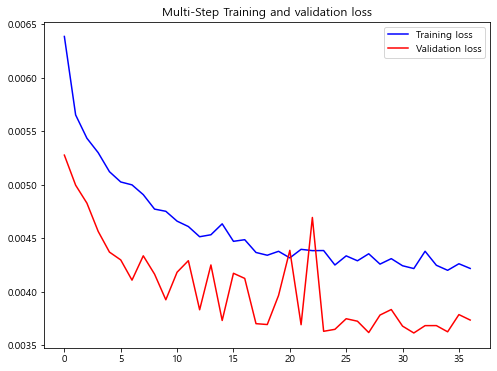

In [85]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

plot_train_history(history, 'Multi-Step Training and validation loss')

In [86]:
trainScore = lstmodel.evaluate(x_train, y_train, verbose=0)
print('Train Score: ',trainScore)

valScore = lstmodel.evaluate(x_valid, y_valid, verbose=0)
print('Validation Score: ',valScore)

Train Score:  0.004147348925471306
Validation Score:  0.0037354843225330114


### 테스트 해 보기
최신 데이터를 다운로드 하여 input 데이터를 넣어 보고 예측해보기!

In [87]:
test = pd.read_csv('./data/testdata2.csv', encoding='CP949')
display(test)

# 날씨 데이터의 NaN 값을 0으로 바꿔준다.
test=test.fillna(0)

,지점,지점명,일시,평균기온(°C),일강수량(mm)
0,268,진도군,2021-05-06,14.7,NaN
1,268,진도군,2021-05-07,16.6,NaN
2,268,진도군,2021-05-08,15.2,NaN
3,268,진도군,2021-05-09,16.4,NaN
4,268,진도군,2021-05-10,18.2,NaN
5,268,진도군,2021-05-11,19.7,NaN
6,268,진도군,2021-05-12,20.0,NaN
7,268,진도군,2021-05-13,19.0,NaN
8,268,진도군,2021-05-14,20.4,0.0
9,268,진도군,2021-05-15,21.7,20.5


In [88]:
# 정규화
from sklearn.preprocessing import MinMaxScaler

test.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols=['평균기온(°C)','일강수량(mm)']
test_scaled=scaler.fit_transform(test[scale_cols])
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns = scale_cols

display(test_scaled)

,평균기온(°C),일강수량(mm)
0,0.000000,0.000000
1,0.240506,0.000000
2,0.063291,0.000000
3,0.215190,0.000000
4,0.443038,0.000000
5,0.632911,0.000000
6,0.670886,0.000000
7,0.544304,0.000000
8,0.721519,0.000000
9,0.886076,0.449561


In [89]:
feature_list = []

for i in range(len(test_scaled) - 20):
    feature_list.append(np.array(test_scaled.iloc[i:i+20]))

test_input = np.array(feature_list)
display(test_input)

array([[[0.        , 0.        ],
        [0.24050633, 0.        ],
        [0.06329114, 0.        ],
        [0.21518987, 0.        ],
        [0.44303797, 0.        ],
        [0.63291139, 0.        ],
        [0.67088608, 0.        ],
        [0.5443038 , 0.        ],
        [0.72151899, 0.        ],
        [0.88607595, 0.4495614 ],
        [0.65822785, 1.        ],
        [0.05063291, 0.01754386],
        [0.18987342, 0.        ],
        [0.59493671, 0.        ],
        [0.18987342, 0.28508772],
        [0.25316456, 0.        ],
        [0.40506329, 0.        ],
        [0.63291139, 0.        ],
        [0.36708861, 0.        ],
        [0.32911392, 0.        ]],

       [[0.24050633, 0.        ],
        [0.06329114, 0.        ],
        [0.21518987, 0.        ],
        [0.44303797, 0.        ],
        [0.63291139, 0.        ],
        [0.67088608, 0.        ],
        [0.5443038 , 0.        ],
        [0.72151899, 0.        ],
        [0.88607595, 0.4495614 ],
        [0.6

In [90]:
test_pred = lstmodel.predict(test_input)
test_pred.shape

(12, 1)

In [91]:
result = scaler1.inverse_transform(test_pred)
print(result)

[[1839.0961]
 [1795.0787]
 [1752.9376]
 [1685.8994]
 [1643.8619]
 [1555.724 ]
 [1459.6068]
 [1351.3895]
 [1230.3348]
 [1248.7379]
 [1171.4801]
 [1029.5309]]


In [92]:
flag=False
# 여기로 쿼리를 불러와서 확인하기!
for date in pandas.date_range(start='20210526', end='20210606'):

    date1 = str(date.strftime("%Y%m%d"))
    date2 = str((date-timedelta(days=1)).strftime("%Y%m%d"))
    date3 = str((date-timedelta(days=365)).strftime("%Y%m%d"))
    query1=query_sender(date1,
                       date2,
                       date3,
                       '대파')

    i_list1=xml_to_item_list(query1, date1)
    check = pd.DataFrame(i_list1)
    check=check.drop(check.index[0])
    if not flag:
        flag = True
        col=['날짜', '품목명', '평균가격', '전일평균가격', '전년가격', '등급']
        check.columns=col
        check.to_csv('./data/check.csv',encoding='utf-8-sig')
    else:
        check.to_csv('./data/check.csv',encoding='utf-8-sig',mode='a', header=False)

check = pd.read_csv('./data/check.csv', index_col=0)
display(check)

,날짜,품목명,평균가격,전일평균가격,전년가격,등급
1,20210526,대파(일반),3601,3662,1868,특
2,20210526,대파(일반),2152,2153,1623,상
3,20210526,대파(일반),1572,1676,1496,중
4,20210526,대파(일반),1180,1392,1208,하
1,20210527,대파(일반),3699,3601,1952,특
2,20210527,대파(일반),1554,2152,1639,상
3,20210527,대파(일반),1247,1572,1500,중
4,20210527,대파(일반),1110,1180,1257,하
1,20210528,대파(일반),3755,3699,1992,특
2,20210528,대파(일반),1594,1554,1628,상


In [93]:
print('## groupby (등급) ##')
cgrouped = check.groupby('등급')

#그룹 확인
result_g = cgrouped.get_group(name='중')
result_g['결과'] = result
display(result_g)




## groupby (등급) ##


c:\201814471\setup\envs\py37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,날짜,품목명,평균가격,전일평균가격,전년가격,등급,결과
3,20210526,대파(일반),1572,1676,1496,중,1839.096069
3,20210527,대파(일반),1247,1572,1500,중,1795.078735
3,20210528,대파(일반),1242,1247,1523,중,1752.937622
3,20210529,대파(일반),1272,1242,1450,중,1685.899414
3,20210530,대파(일반),0,1272,1444,중,1643.861938
3,20210531,대파(일반),1306,0,0,중,1555.723999
3,20210601,대파(일반),1362,1306,1083,중,1459.606812
3,20210602,대파(일반),1417,1362,1215,중,1351.389526
3,20210603,대파(일반),1209,1417,1358,중,1230.334839
3,20210604,대파(일반),1209,1209,1319,중,1248.737915
